# DHJ, SHJ, etc

In [1]:
import warnings
from datetime import datetime, timedelta
from dataclasses import dataclass, field
from functools import partial
import aeolus
import dask.array as da
import iris
from cf_units import Unit
from copy import deepcopy
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import paths
from aeolus.calc import last_n_day_mean, spatial_mean, zonal_mean, meridional_mean
from aeolus.coord import (
    isel,
    interp_cube_from_height_to_pressure_levels,
    regrid_3d,
    roll_cube_pm180,
    wrap_lons,
    roll_cube_0_360,
)
from aeolus.lfric import load_lfric_raw
from aeolus.model import lfric, um
from aeolus.plot import (
    figsave,
    tex2cf_units,
    unit_format,
    hcross,
    map_scatter,
    capitalise,
)
from common import (
    # EXPERIMENTS,
    MODELS,
    Experiment,
    Diag,
    replace_z_coord,
    lfric_callback_uniform_height,
)

CNORM = {"norm": mcol.CenteredNorm(vcenter=0), "cmap": "RdBu_r"}

warnings.filterwarnings("ignore")
iris.FUTURE.date_microseconds = True

lfric.w = "w_in_w3"
lfric.dt_force = "temperature_increment_from_external_forcing"
um.dt_force = "m01s53i181"

In [2]:
from aeolus.const import init_const

EXPERIMENTS = {
    "dhj_debug": Experiment(
        title="Deep Hot Jupiter",
        const=init_const("dhj", directory=paths.const),
        group="tf",
    ),
}

In [3]:
ds_all = {}

for exp_label in ["dhj_debug"]:
    model_name = "lfric"
    fnames = sorted(
        (paths.data_work / model_name / exp_label).glob("lfric_diag_latlon*.nc")
    )
    ds_all[model_name] = load_lfric_raw(
        fnames,
        callback=partial(
            lfric_callback_uniform_height,
            model_top_height=EXPERIMENTS[exp_label].const.domain_height.data,
        ),
    )
    for cube in ds_all[model_name]:
        if cube.name() == lfric.dt_force:
            cube.units /= f"{MODELS[model_name].timestep} s"

    model_name = "um"
    fnames = paths.data_work / model_name / exp_label / "atmosa.p*"
    ds_all[model_name] = iris.load(fnames)
    for cube in ds_all[model_name]:
        try:
            cube.coord(MODELS[model_name].model.z).bounds = None
            replace_z_coord(
                cube,
                inplace=True,
                remove_level_coord=True,
                model=MODELS[model_name].model,
            )
        except iris.exceptions.CoordinateNotFoundError:
            pass
        stash_str = str(cube.attributes["STASH"])
        if stash_str in ["m01s13i385", "m01s13i386"]:
            cube.units = Unit("m s-1")
        elif stash_str in ["m01s53i181"]:
            cube.units = Unit("K")
        if stash_str in ["m01s53i181", "m01s13i385", "m01s13i386"]:
            cube.units /= f"{MODELS[model_name].timestep} s"

    for model_name in MODELS:
        print(ds_all[model_name])
        print()
        _ds_regr = iris.cube.CubeList()
        for cube in ds_all[model_name]:
            if model_name == "um":
                cube.data = da.roll(
                    cube.core_data(), len(cube.coord("longitude").points) // 2, axis=-1
                )
                cube = roll_cube_0_360(roll_cube_pm180(cube))
            if lfric.z in [i.name() for i in cube.dim_coords]:
                _ds_regr.append(
                    regrid_3d(
                        cube,
                        ds_all[model_name].extract_cube("air_pressure"),
                        model=MODELS[model_name].model,
                    )
                )

        ds_all[model_name] = _ds_regr

        print(ds_all[model_name])
        print()
        print()

0: air_pressure / (Pa)                 (time: 39; level_height: 67; latitude: 90; longitude: 144)
1: air_temperature / (K)               (time: 39; level_height: 67; latitude: 90; longitude: 144)
2: eastward_wind / (m s-1)             (time: 39; level_height: 66; latitude: 90; longitude: 144)
3: exner_pressure_at_cell_interfaces / (1) (time: 39; level_height: 67; latitude: 90; longitude: 144)
4: northward_wind / (m s-1)            (time: 39; level_height: 66; latitude: 90; longitude: 144)
5: temperature_increment_from_external_forcing / (0.000833333333333333 s-1.K) (time: 39; level_height: 67; latitude: 90; longitude: 144)
6: upward_air_velocity / (m s-1)       (time: 39; level_height: 66; latitude: 90; longitude: 144)

0: air_pressure / (Pa)                 (time: 39; level_height: 67; latitude: 90; longitude: 144)
1: air_temperature / (K)               (time: 39; level_height: 67; latitude: 90; longitude: 144)
2: eastward_wind / (m s-1)             (time: 39; level_height: 67; latitu

## 2d cross-sections

In [4]:
DIAGS = {
    "temp": Diag(
        title="Air Temperature",
        units="$K$",
        recipe=lambda cl, model: cl.extract_cube(model.temp),
        kw_plt={"cmap": "plasma"},
    ),
    "u": Diag(
        title="Eastward Wind",
        units="$m$ $s^{-1}$",
        cnorm=True,
        recipe=lambda cl, model: cl.extract_cube(model.u),
        kw_plt={"cmap": "RdYlBu_r"},
    ),
    "v": Diag(
        title="Northward Wind",
        units="$m$ $s^{-1}$",
        cnorm=True,
        recipe=lambda cl, model: cl.extract_cube(model.v),
        kw_plt={"cmap": "RdYlBu_r"},
    ),
    "w": Diag(
        title="Upward Wind",
        units="$m$ $s^{-1}$",
        recipe=lambda cl, model: cl.extract_cube(model.w),
        cnorm=True,
        kw_plt={"cmap": "PuOr_r"},
    ),
    "dt_force": Diag(
        title="Temperature Increment from Forcing",
        units="$K$ $s^{-1}$",
        recipe=lambda cl, model: cl.extract_cube(model.dt_force),
        cnorm=True,
        kw_plt={"cmap": "RdBu_r"},
    ),
}

In [5]:
from iris.coords import DimCoord, AuxCoord
from typing import Optional


def dissect_lfric_um(
    exp_label: str,
    diag_key: str,
    tstamp: datetime,
    xsec_ax: str | DimCoord | AuxCoord,
    xsec_val: Optional[float | int] = None,
) -> plt.Figure:
    """Dissect and compare LFRic and UM model outputs for a given experiment, diagnostic, and timestamp."""
    COORD_MAP = {
        "x": {
            "x-ax": "y",
            "y-ax": "z",
            "lim": (0, 360),
            "ticks": np.arange(0, 361, 60),
            "alt_collapse_func": zonal_mean,
        },
        "y": {
            "x-ax": "x",
            "y-ax": "z",
            "lim": (-90, 90),
            "ticks": np.arange(-90, 91, 30),
            "alt_collapse_func": meridional_mean,
        },
        "z": {
            "x-ax": "x",
            "y-ax": "y",
        },
    }
    if xsec_val is not None:
        collapse_label = f"at_{xsec_ax}{xsec_val:.0f}"
    else:
        collapse_label = f"{xsec_ax}mean"

    def _collapse_func(cube, tstamp, model):
        if xsec_val is None:
            res = COORD_MAP[xsec_ax]["alt_collapse_func"](cube, model=model)
        else:
            res = cube.interpolate(
                [(getattr(model, xsec_ax), xsec_val)], iris.analysis.Linear()
            )
        return res.extract(iris.Constraint(**{model.t: lambda x: x.point == tstamp}))

    fig = plt.figure(figsize=(4 * len(MODELS), 3), layout="constrained")
    axd = fig.subplot_mosaic(
        [
            [*MODELS.keys()],
            [f"cbar_{i}" for i in MODELS.keys()],
        ],
        gridspec_kw={"height_ratios": [1, 0.05]},
    )
    models_present = 0
    ts = 0
    for model_name in MODELS:
        mdl = MODELS[model_name].model
        ax = axd[model_name]
        ax.set_title(
            f"{MODELS[model_name].title} | dt={MODELS[model_name].timestep} s",
        )
        cube = DIAGS[diag_key].recipe(ds_all[model_name], model=mdl)
        coord_t = cube.coord(mdl.t)
        cube = _collapse_func(cube, tstamp=tstamp, model=mdl)

        if cube is None:
            ax.set_xticks([])
            ax.set_yticks([])
            axd[f"cbar_{model_name}"].remove()
            continue
        models_present += 1
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        ts = coord_t.units.num2date(coord_t.points).tolist().index(tstamp)
        ax.set_title(f"ts: {ts:>6d}", loc="right")

        coord_x = cube.coord(getattr(mdl, COORD_MAP[xsec_ax]["x-ax"]))
        coord_y = cube.coord(getattr(mdl, COORD_MAP[xsec_ax]["y-ax"]))
        coord_xsec = cube.coord(getattr(mdl, xsec_ax))
        cntr = ax.contourf(
            coord_x.points,
            coord_y.points,
            cube.data,
            norm=mcol.CenteredNorm(vcenter=0.0) if DIAGS[diag_key].cnorm else None,
            **DIAGS[diag_key].kw_plt,
        )
        fig.colorbar(cntr, cax=axd[f"cbar_{model_name}"], orientation="horizontal")
        ax.set_xlim(COORD_MAP[COORD_MAP[xsec_ax]["x-ax"]].get("lim"))
        if (ticks := COORD_MAP[COORD_MAP[xsec_ax]["x-ax"]].get("ticks")) is not None:
            ax.set_xticks(ticks)
        ax.set_xlabel(f"{capitalise(coord_x.name())} / {coord_x.units}")
        ax.set_ylim(COORD_MAP[COORD_MAP[xsec_ax]["y-ax"]].get("lim"))
        ax.set_ylabel(f"{capitalise(coord_y.name())} / {coord_y.units}")
        if (ticks := COORD_MAP[COORD_MAP[xsec_ax]["y-ax"]].get("ticks")) is not None:
            ax.set_yticks(ticks)
        ax.grid(True, linestyle="--", alpha=0.5, dash_capstyle="round")

    if models_present:
        slice_label = (
            f"{capitalise(coord_x.name())}-{capitalise(coord_y.name())} Slice of "
        )
        if xsec_val is not None:
            xsec_loc_title = (
                f"@ {capitalise(coord_xsec.name())} = {xsec_val} {coord_xsec.units}"
            )
        else:
            xsec_loc_title = f"{capitalise(coord_xsec.name())}-Mean"
    else:
        slice_label = " "
        xsec_loc_title = " "

    fig.suptitle(
        "\n".join(
            [
                f"{EXPERIMENTS[exp_label].title}",
                slice_label + f"{DIAGS[diag_key].title} / {DIAGS[diag_key].units}",
                xsec_loc_title,
            ]
        ),
    )

    xyz_label = (
        f"{COORD_MAP[xsec_ax]['x-ax']}{COORD_MAP[xsec_ax]['y-ax']}_{collapse_label}"
    )

    fig_name = f"{exp_label}__{'_'.join(MODELS)}__{diag_key}__{xyz_label}__ts{ts:06d}"

    return fig, fig_name


In [13]:
exp_label = "dhj_debug"

times = [datetime(2000, 1, 1, 0, 0, 0) + timedelta(seconds=1200 * i) for i in range(39)]

for diag_key in ["temp", "u", "v", "w", "dt_force"]:
    for ts, tstamp in enumerate(times):
        fig, fig_name = dissect_lfric_um(exp_label, diag_key, tstamp, "z", 1.1e7)
        figsave(
            fig,
            paths.drafts / exp_label / fig_name,
        )
        plt.close(fig)


Saved to ../figures/drafts/dhj_debug/dhj_debug__lfric_um__temp__xy_at_z11000000__ts000000.pdf
Size: 27.7 KB
Saved to ../figures/drafts/dhj_debug/dhj_debug__lfric_um__temp__xy_at_z11000000__ts000001.pdf
Size: 60.5 KB
Saved to ../figures/drafts/dhj_debug/dhj_debug__lfric_um__temp__xy_at_z11000000__ts000002.pdf
Size: 65.2 KB
Saved to ../figures/drafts/dhj_debug/dhj_debug__lfric_um__temp__xy_at_z11000000__ts000003.pdf
Size: 66.5 KB
Saved to ../figures/drafts/dhj_debug/dhj_debug__lfric_um__temp__xy_at_z11000000__ts000004.pdf
Size: 67.2 KB
Saved to ../figures/drafts/dhj_debug/dhj_debug__lfric_um__temp__xy_at_z11000000__ts000005.pdf
Size: 67.5 KB
Saved to ../figures/drafts/dhj_debug/dhj_debug__lfric_um__temp__xy_at_z11000000__ts000006.pdf
Size: 67.7 KB
Saved to ../figures/drafts/dhj_debug/dhj_debug__lfric_um__temp__xy_at_z11000000__ts000007.pdf
Size: 67.6 KB
Saved to ../figures/drafts/dhj_debug/dhj_debug__lfric_um__temp__xy_at_z11000000__ts000008.pdf
Size: 68.0 KB
Saved to ../figures/drafts/d

In [7]:
model_name = "lfric"
exp_label = "dhj_debug"
ds_native = load_lfric_raw(
    sorted((paths.data_work / model_name / exp_label).glob("lfric_diag_native*.nc")),
    callback=partial(
        combi_callback,
        model_top_height=EXPERIMENTS[exp_label].const.domain_height.data,
    ),
)

NameError: name 'combi_callback' is not defined

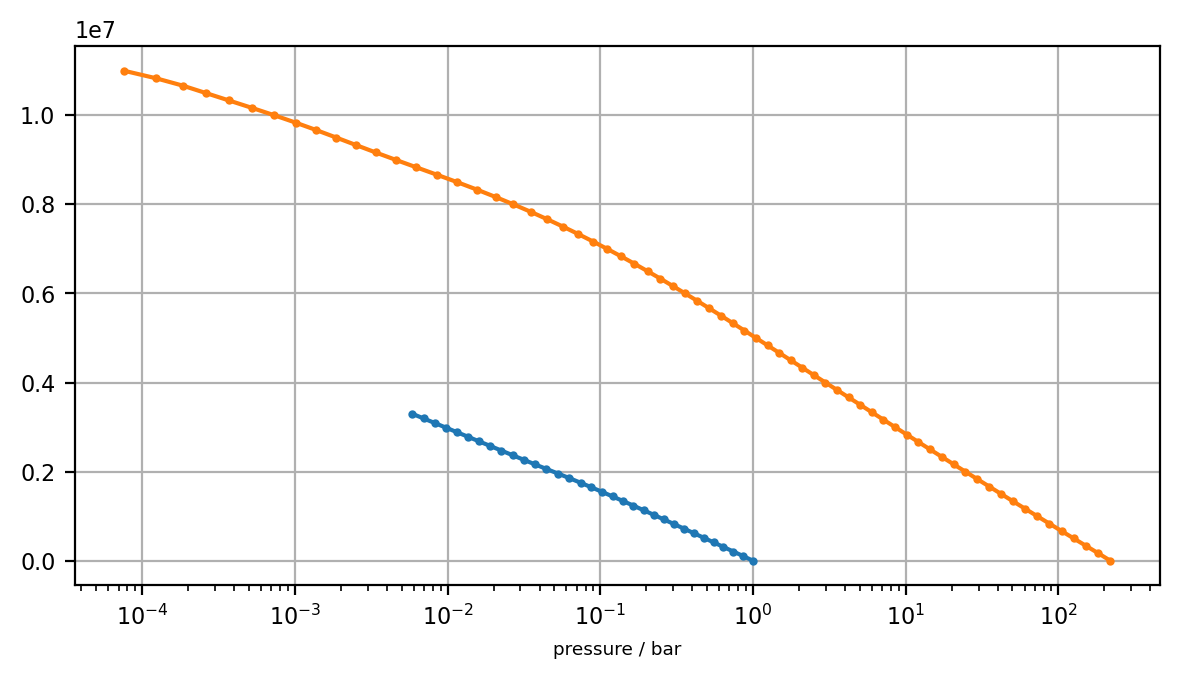

In [ ]:
fig, ax = plt.subplots()

for exp_label in ["shj", "dhj"]:
    pres = ds_all["lfric"][exp_label].extract_cube(lfric.pres)

    ax.plot(pres[0, :, 45, 72].data / 1e5, pres.coord(lfric.z).points, "-o", ms=2)
# ax.set_xlim(2e5, 5e2)

ax.set_xlabel("pressure / bar")
ax.set_xscale("log")
ax.grid()

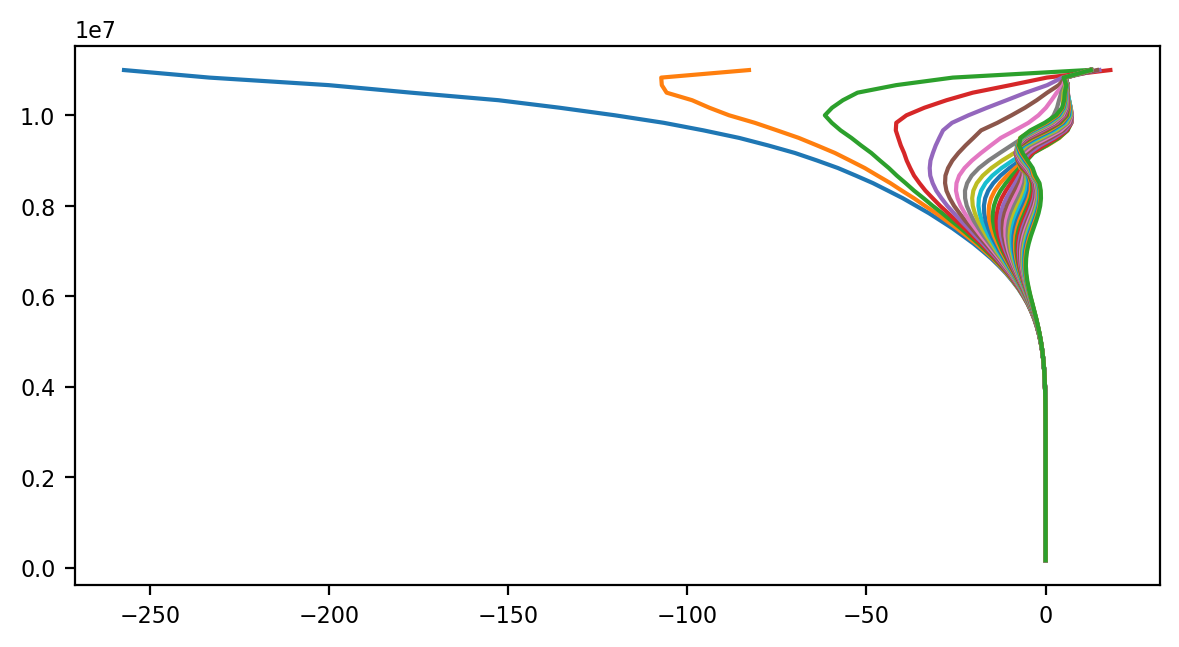

In [ ]:
ax = plt.axes()
for idx in range(33):
    ax.plot(
        ds_all["um"].extract_cube("m01s53i181")[idx, :, 45, 0].data,
        ds_all["um"].extract_cube("m01s53i181").coord(um.z).points,
    )

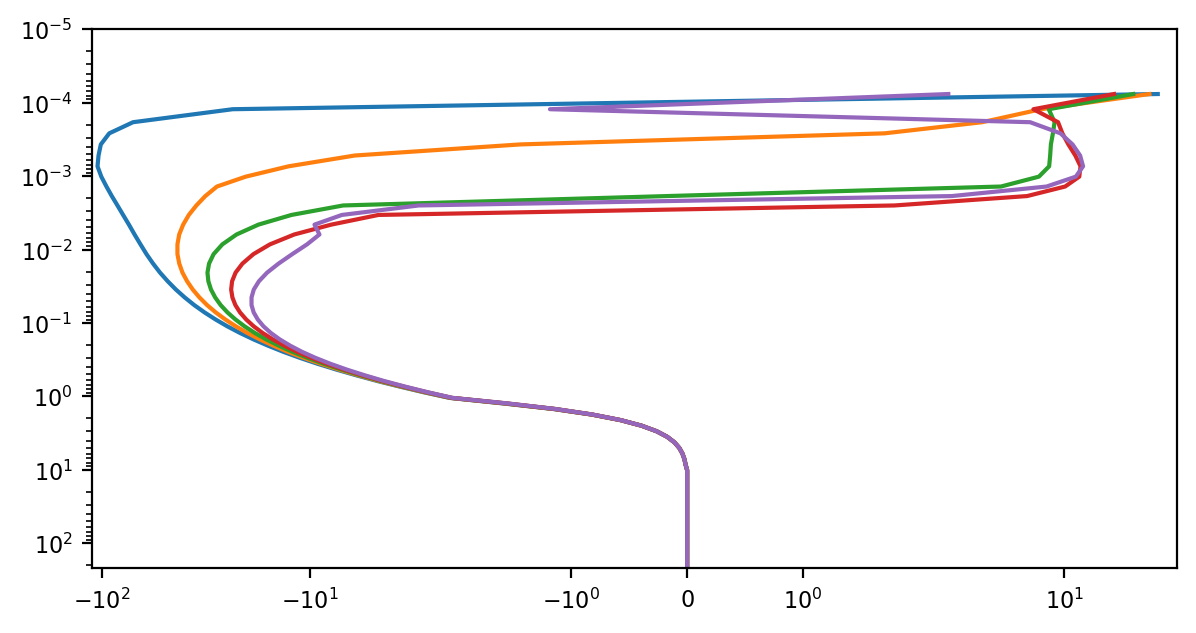

In [ ]:
ax = plt.axes()
for cube_slice in ds.extract_cube("dt_force").slices_over(lfric.t):
    ax.plot(
        cube_slice[:, 45, 72].data,
        ds.extract_cube("air_pressure")[0, :, 45, 72].data / 1e5,
    )  # cube_slice.coord(lfric.z).points
ax.set_yscale("log")
ax.set_ylim(2.2e2, 1e-5)
ax.set_xscale("symlog")

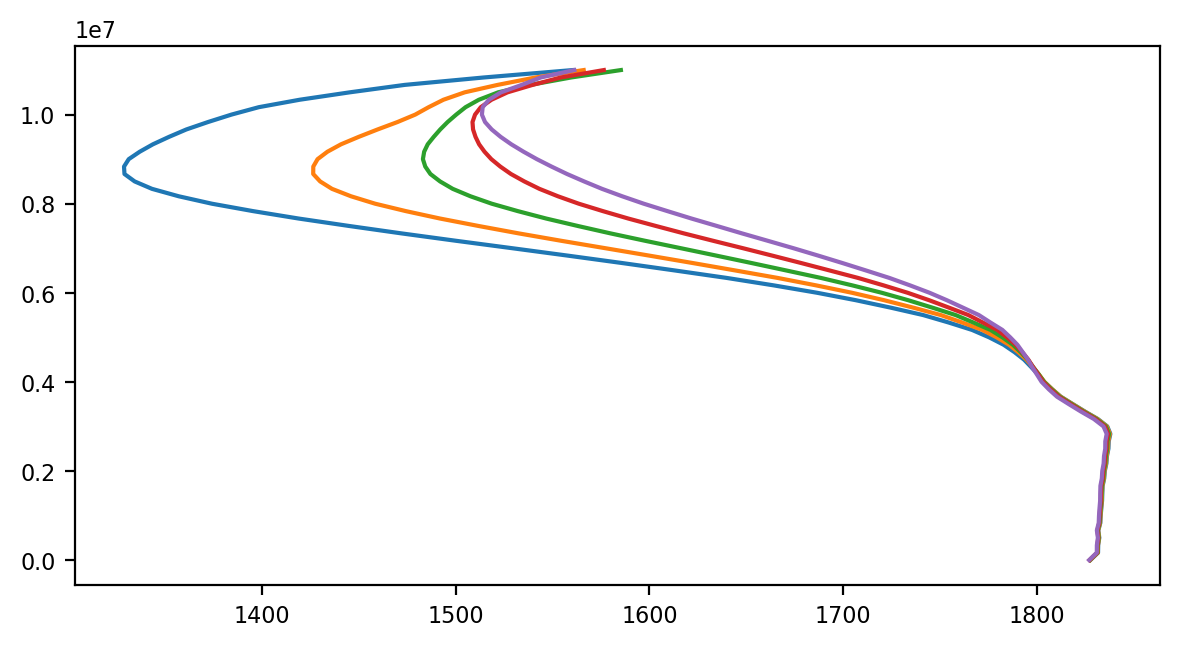

In [ ]:
ax = plt.axes()
for cube_slice in ds.extract_cube("air_temperature").slices_over(lfric.t):
    ax.plot(cube_slice[:, 45, 0].data, cube_slice.coord(lfric.z).points)